In [10]:
import numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
from celerite.modeling import Model, ConstantModel
import muhz2days
import autocorr
from scipy.ndimage.filters import gaussian_filter
from astropy.stats import LombScargle

In [11]:
del pool

In [12]:
from multiprocessing import Pool
pool = Pool()

In [13]:
muhzconv = 1e6 / (3600*24)

def muhz2idays(muhz):
    return muhz / muhzconv

def muhz2omega(muhz):
    return muhz2idays(muhz) * 2.0 * np.pi

def idays2muhz(idays):
    return idays * muhzconv

def omega2muhz(omega):
    return idays2muhz(omega / (2.0 * np.pi))

omega = np.linspace(1, 300, 1000)
freqmuhz = omega2muhz(omega)
freqidays = muhz2idays(freqmuhz)
plt.loglog(omega, kernel.get_psd(omega));

ERROR: NameError: name 'kernel' is not defined [IPython.core.interactiveshell]


NameError: name 'kernel' is not defined

['/Users/samuelgrunblatt/Desktop/guysstars/20Stars/Data/kplr11819363_llc_concat.dat', '/Users/samuelgrunblatt/Desktop/guysstars/20Stars/Data/kplr11234897_llc_concat.dat', '/Users/samuelgrunblatt/Desktop/guysstars/20Stars/Data/kplr10587122_llc_concat.dat', '/Users/samuelgrunblatt/Desktop/guysstars/20Stars/Data/kplr9517698_llc_concat.dat', '/Users/samuelgrunblatt/Desktop/guysstars/20Stars/Data/kplr10522084_llc_concat.dat', '/Users/samuelgrunblatt/Desktop/guysstars/20Stars/Data/kplr11029423_llc_concat.dat', '/Users/samuelgrunblatt/Desktop/guysstars/20Stars/Data/kplr7014894_llc_concat.dat', '/Users/samuelgrunblatt/Desktop/guysstars/20Stars/Data/kplr11600024_llc_concat.dat', '/Users/samuelgrunblatt/Desktop/guysstars/20Stars/Data/kplr10146348_llc_concat.dat', '/Users/samuelgrunblatt/Desktop/guysstars/20Stars/Data/kplr7944038_llc_concat.dat', '/Users/samuelgrunblatt/Desktop/guysstars/20Stars/Data/kplr8543200_llc_concat.dat', '/Users/samuelgrunblatt/Desktop/guysstars/20Stars/Data/kplr11665692_

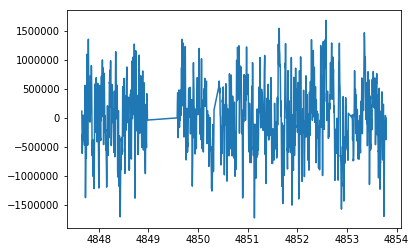

In [17]:
#data = np.loadtxt('/Users/samuelgrunblatt/Desktop/quicklook/211351816.dat.ts')
#data = np.loadtxt('/Users/samuelgrunblatt/Desktop/asterointimedom/kplr1162746_llc_concat.dat') # Using Guy's star
#log_numax = np.log(25)
#log_dnu = np.log(3.0)

import glob
datalist = []
for name in glob.glob('/Users/samuelgrunblatt/Desktop/guysstars/20Stars/Data/*.dat'): #Using one of Guy's stars!
    datalist.append(name)
print(datalist)

data = np.loadtxt(datalist[10])

t = np.array(data[:, 0]*0.0864)[:3000]
y = np.array(data[:, 1:2]*1e3)[:3000]

log_var = np.log(np.var(data[:,1]*1e3))

df = 0.01 / (np.max(t) - np.min(t))
freq = np.arange(10.0, 0.5 / np.median(np.diff(t)), df)
len(freq)

plt.plot(t, y[:,0])

model = LombScargle(t, y[:,0])
power = model.power(freq)

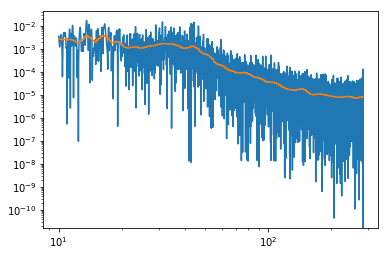

In [19]:
def estimate_background(x, y, log_width=0.02):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

bkg = estimate_background(freq, power)
plt.loglog(freq, power)
plt.plot(freq, bkg)

In [20]:
df = freq[1] - freq[0]
smoothed_ps = gaussian_filter(power / bkg, 5 / df)

# And the autocorrelation function of a lightly smoothed power spectrum
acor_func = autocorr.function_1d(gaussian_filter(power / bkg, 0.5 / df))
lags = df*np.arange(len(acor_func))
acor_func = acor_func[lags < 30]
lags = lags[lags < 30]

# Find the peaks
def find_peaks(z):
    peak_inds = (z[1:-1] > z[:-2]) * (z[1:-1] > z[2:])
    peak_inds = np.arange(1, len(z)-1)[peak_inds]
    peak_inds = peak_inds[np.argsort(z[peak_inds])][::-1]
    return peak_inds

peak_freqs = freq[find_peaks(smoothed_ps)]
nu_max = peak_freqs[peak_freqs > 5][0]

# Expected delta_nu: Stello et al (2009)
dnu_expected = 0.263 * nu_max ** 0.772
peak_lags = lags[find_peaks(acor_func)]
delta_nu = peak_lags[np.argmin(np.abs(peak_lags - dnu_expected))]
print("nu_max = {0}, delta_nu = {1}".format(nu_max, delta_nu))

nu_max = 43.74063930858961, delta_nu = 3.999035556103138


In [25]:
class ASTerm(terms.SHOTerm):
    parameter_names = ("log_numax", "log_dnu", "gamma_0", "gamma_1", "log_H0", "log_H1", "log_sigma", "log_Q")
    def get_all_coefficients(self, params=None):
        if params is None:
            params = self.get_parameter_vector(include_frozen=True)
        log_numax, log_dnu, gamma_0, gamma_1, log_H0, log_H1, log_sigma, log_Q = params
        gamma = np.array([gamma_0, gamma_1])
        H = np.exp([log_H0, log_H1])
        nunl, ampnl = self.modelfreq(np.exp(log_numax), np.exp(log_dnu), gamma, H, np.exp(log_sigma))
        coeffs = []
        for j in range(nunl.size):
            nu, amp = nunl.flat[j], ampnl.flat[j]
            log_S0 = np.log(amp)-2*log_Q
            log_omega = np.log(2*np.pi*nu)
            coeffs.append(super(ASTerm,self).get_all_coefficients([log_S0, log_Q, log_omega]))
        return [np.concatenate(args) for args in zip(*coeffs)]
        
    def modelfreq(self, numax, dnu, gammas, Hs, sigma):
        nprime = np.arange(-2,3,1)
        l = np.arange(len(gammas))
        nunl= numax + gammas[None,:] + (dnu * (nprime[:,None] + l[None,:]/2.))
        Anl = Hs[None,:]*np.exp(-(nunl - numax)**2/(2*sigma**2))
        return nunl, Anl

In [26]:
log_var = np.log(np.var(data[:, 1]))
k1 = ASTerm(
    log_numax=log_numax,
    log_dnu=log_dnu,
    gamma_0=0.0,
    gamma_1=0.0,
    log_H0=log_var,
    log_H1=log_var,
    log_sigma=np.log(10.0),
    log_Q=8.
)

k1.freeze_all_parameters()

k2 = terms.SHOTerm(log_Q=-0.5*np.log(2), log_S0=log_var, log_omega0=np.log(100))
k2.freeze_parameter("log_Q")

k3 = terms.SHOTerm(log_Q=-0.5*np.log(2), log_S0=log_var, log_omega0=np.log(150))
k3.freeze_parameter("log_Q")

k4 = terms.JitterTerm(0.5*log_var)

kernel = k1 + k2 + k3 + k4

ERROR: NameError: name 'log_numax' is not defined [IPython.core.interactiveshell]


NameError: name 'log_numax' is not defined

In [336]:
kernel.coefficients

[array([], dtype=float64),
 array([], dtype=float64),
 array([2.18139861e+04, 2.54645486e+04, 2.89090531e+04, 3.19401158e+04,
        3.43632669e+04, 3.60175774e+04, 3.67933403e+04, 3.66441065e+04,
        3.55912404e+04, 3.37203812e+04, 4.61121558e+07, 6.91682337e+07]),
 array([3.65888860e+00, 4.27120226e+00, 4.84895352e+00, 5.35735767e+00,
        5.76379600e+00, 6.04127567e+00, 6.17139539e+00, 6.14636422e+00,
        5.96976561e+00, 5.65596392e+00, 4.61121558e+07, 6.91682337e+07]),
 array([2.00238516e-02, 2.16046820e-02, 2.31855124e-02, 2.47663428e-02,
        2.63471732e-02, 2.79280036e-02, 2.95088340e-02, 3.10896644e-02,
        3.26704947e-02, 3.42513251e-02, 7.07106781e+01, 1.06066017e+02]),
 array([119.38051916, 128.80529699, 138.23007481, 147.65485264,
        157.07963047, 166.5044083 , 175.92918613, 185.35396395,
        194.77874178, 204.20351961,  70.71067812, 106.06601718])]

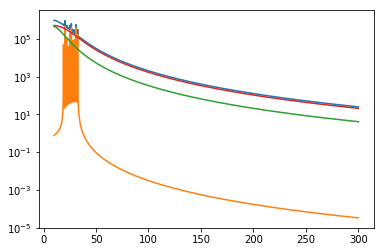

In [337]:
freq_muHz = np.linspace(10, 300, 10000)
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [338]:
time,flux = sorted(np.array(data[:,0])*0.0864)[:2000], np.array(data[:,1])[:2000]

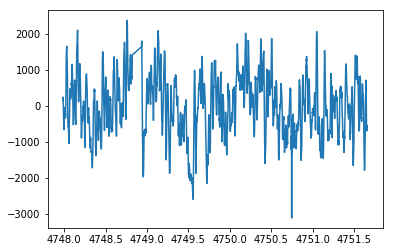

In [339]:
plt.plot(time,flux)

In [340]:
gp = celerite.GP(kernel)
gp.compute(time)

In [341]:
def nll(params):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(flux)

In [342]:
from scipy.optimize import minimize

soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
soln

      fun: 13206.366955705053
 hess_inv: array([[ 5.59329624e-03, -7.38917834e-07, -9.55551637e-03,
         1.59373532e-03, -2.91534070e-04],
       [-7.38917834e-07,  1.52839089e-09,  6.75724129e-06,
        -1.09811264e-06, -2.22710695e-07],
       [-9.55551637e-03,  6.75724129e-06,  4.06727953e-02,
        -7.39205355e-03, -6.83904680e-04],
       [ 1.59373532e-03, -1.09811264e-06, -7.39205355e-03,
         2.11776976e-03,  1.86086272e-04],
       [-2.91534070e-04, -2.22710695e-07, -6.83904680e-04,
         1.86086272e-04,  2.74362994e-04]])
      jac: array([-2.70751953e-01, -1.45788574e+01, -8.30078125e-03, -4.88281250e-02,
       -6.73828125e-02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1025
      nit: 39
     njev: 144
   status: 2
  success: False
        x: array([ 8.8882723 ,  4.84281769, -2.90311328,  7.71785812,  4.36421512])

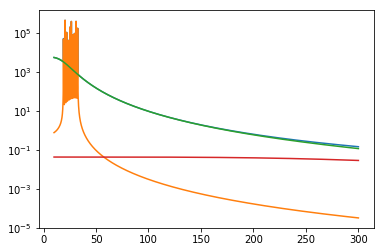

In [343]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

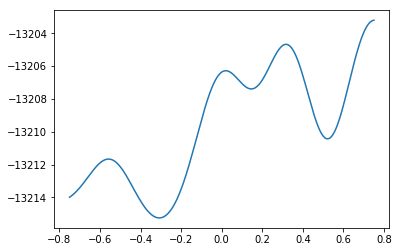

In [344]:
gammagrid = np.linspace(-0.25*np.exp(log_dnu),0.25*np.exp(log_dnu), 500)
like = np.empty_like(gammagrid)
for i,gamma in enumerate(gammagrid):
    k1.set_parameter("gamma_1", gamma)
    like[i] = gp.log_likelihood(flux)
best = gammagrid[np.argmax(like)]
k1.set_parameter("gamma_1", best)
plt.plot(gammagrid,like)

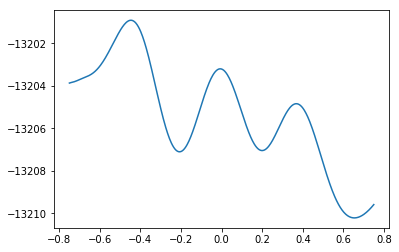

In [345]:
gammagrid = np.linspace(-0.25*np.exp(log_dnu),0.25*np.exp(log_dnu), 500)
like = np.empty_like(gammagrid)
for i,gamma in enumerate(gammagrid):
    k1.set_parameter("gamma_0", gamma)
    like[i] = gp.log_likelihood(flux)
best = gammagrid[np.argmax(like)]
k1.set_parameter("gamma_0", best)
plt.plot(gammagrid,like)

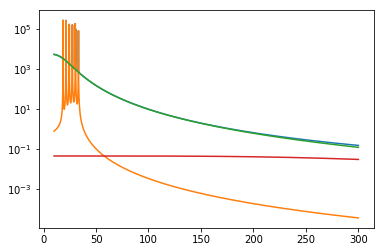

In [346]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [347]:
k1.thaw_parameter("gamma_0")
k1.thaw_parameter("gamma_1")
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
soln

      fun: 13200.273221079638
 hess_inv: array([[ 8.45676443e-04, -4.79282923e-05, -2.11090469e-04,
         2.50268079e-05,  2.57921229e-03, -4.61800042e-04,
        -1.02726170e-02],
       [-4.79282923e-05,  7.52498180e-04, -7.18067098e-05,
        -2.00770607e-05, -1.15877150e-03, -4.09230947e-04,
         5.53081480e-03],
       [-2.11090469e-04, -7.18067098e-05,  1.88105286e-03,
        -1.52346251e-05, -1.99055865e-03,  4.13722590e-04,
         5.19498355e-03],
       [ 2.50268079e-05, -2.00770607e-05, -1.52346251e-05,
         1.37495601e-05,  7.88640192e-04,  2.55723023e-04,
        -3.61859902e-03],
       [ 2.57921229e-03, -1.15877150e-03, -1.99055865e-03,
         7.88640192e-04,  4.97962522e-02,  1.25656667e-02,
        -2.12810978e-01],
       [-4.61800042e-04, -4.09230947e-04,  4.13722590e-04,
         2.55723023e-04,  1.25656667e-02,  6.67107773e-03,
        -6.28007950e-02],
       [-1.02726170e-02,  5.53081480e-03,  5.19498355e-03,
        -3.61859902e-03, -2.12810978

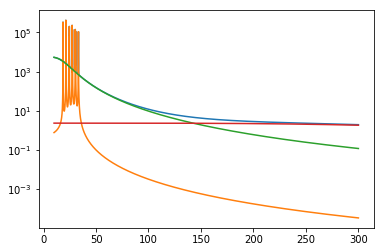

In [348]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [349]:
k1.thaw_parameter("log_H0")
k1.thaw_parameter("log_H1")
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
soln

      fun: 13200.273221079638
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1]])
      jac: array([ 0.83276367, -0.06396484,  2.89990234,  3.62011719, -0.66577148,
       33.01196289, -0.67407227,  0.08154297, -0.04199219])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1101
      nit: 0
     njev: 99
   status: 2
  success: False
        x: array([-0.44578497,  0.75164441, 13.38799056, 13.38799056,  8.86205086,
        4.85031855,  1.07612226,  7.86317702,  3.18861847])

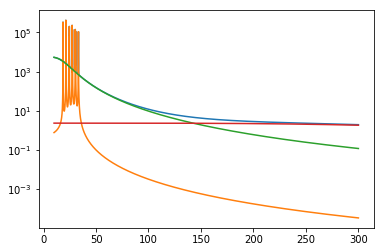

In [295]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

      fun: 13193.01667732617
 hess_inv: array([[ 4.67313251e-06, -1.11723302e-06, -2.14040878e-05,
        -1.12080499e-04, -3.24598394e-06,  2.04272375e-05,
         5.70919595e-08, -1.43796325e-05, -6.46951669e-07,
        -1.66045644e-04],
       [-1.11723302e-06,  1.18774578e-05, -2.60232164e-06,
         8.38934620e-05,  2.36235247e-06, -1.12526968e-05,
        -1.43626114e-08,  4.59315912e-05, -1.47035819e-06,
         2.45521835e-04],
       [-2.14040878e-05, -2.60232164e-06,  8.19570904e-02,
        -2.99913468e-02,  1.14509905e-04,  1.37533023e-03,
         5.19418862e-06, -1.69886586e-03, -9.06023810e-05,
        -4.83926138e-02],
       [-1.12080499e-04,  8.38934620e-05, -2.99913468e-02,
         9.10358553e-02,  9.28912893e-05,  1.29176988e-03,
        -1.06774716e-05, -1.42046042e-03, -1.53291521e-04,
         1.60984451e-02],
       [-3.24598394e-06,  2.36235247e-06,  1.14509905e-04,
         9.28912893e-05,  6.27250533e-06, -2.97375012e-05,
        -5.69246541e-08,  3.08

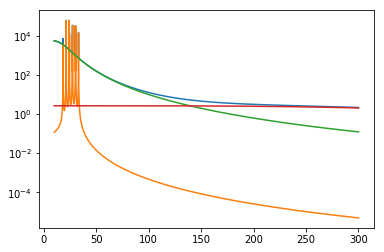

In [296]:
k1.thaw_parameter("log_Q")
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
print(soln)

plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [297]:
# k1.thaw_parameter("log_sigma")
# soln = minimize(nll, gp.get_parameter_vector())
# gp.set_parameter_vector(soln.x)
# print(soln)

# plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
# for term in kernel.terms:
#     plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

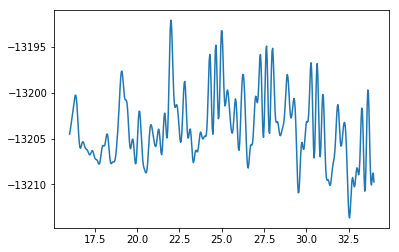

In [298]:
numaxgrid = np.linspace(-3*np.exp(log_dnu),3*np.exp(log_dnu), 500)+np.exp(log_numax)
like = np.empty_like(numaxgrid)
for i,numax in enumerate(numaxgrid):
    k1.set_parameter("log_numax", np.log(numax))
    like[i] = gp.log_likelihood(flux)
best = numaxgrid[np.argmax(like)]
k1.set_parameter("log_numax", np.log(best))
plt.plot(numaxgrid,like)

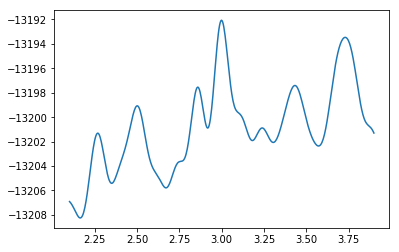

In [299]:
dnugrid = np.linspace(-0.3*np.exp(log_dnu),0.3*np.exp(log_dnu), 500)+np.exp(log_dnu)
like = np.empty_like(dnugrid)
for i,dnu in enumerate(dnugrid):
    k1.set_parameter("log_dnu", np.log(dnu))
    like[i] = gp.log_likelihood(flux)
best = dnugrid[np.argmax(like)]
k1.set_parameter("log_dnu", np.log(best))
plt.plot(dnugrid,like)

      fun: 13188.093649349215
 hess_inv: array([[ 3.89654705e-07, -1.49728021e-07, -5.83042926e-07,
        -2.76581138e-07, -4.52518292e-05, -2.51225218e-06,
        -3.16422241e-06,  1.57043839e-07,  5.83659004e-06,
         3.45672967e-09,  3.41855255e-07,  1.14368970e-08,
        -6.68245616e-06],
       [-1.49728021e-07,  3.08241401e-07, -1.45990651e-07,
        -4.50608066e-08,  1.78944009e-05, -1.01530519e-05,
         1.85226443e-05,  4.22498417e-08, -2.48809102e-09,
         3.18817910e-11,  9.61403754e-08,  8.27657740e-08,
        -2.73093813e-05],
       [-5.83042926e-07, -1.45990651e-07,  1.88194563e-06,
         8.32794895e-07,  6.33205819e-05,  2.92917140e-05,
        -5.83960958e-05, -4.93120297e-07, -9.94041659e-06,
        -7.94707399e-09, -3.39594779e-06, -1.99781124e-07,
         1.15701486e-04],
       [-2.76581138e-07, -4.50608066e-08,  8.32794895e-07,
         1.52067806e-06,  1.64116788e-05,  3.74180272e-05,
        -1.18046139e-05, -7.67145345e-07, -5.85867397e-

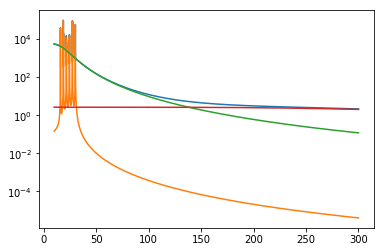

In [300]:
k1.thaw_all_parameters()
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
print(soln)

plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [301]:
from astropy.stats import LombScargle

model = LombScargle(time, flux)
power = model.power(freq_muHz)

(3e-05, 0.1)

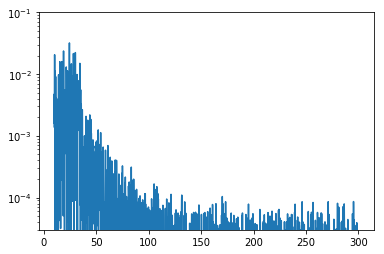

In [305]:
plt.semilogy(freq_muHz, power)
plt.ylim(3e-5,1e-1)

In [306]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_numax', 3.0977885626460804),
             ('kernel:terms[0]:log_dnu', 1.0519483656974213),
             ('kernel:terms[0]:gamma_0', -0.3871332622790588),
             ('kernel:terms[0]:gamma_1', 0.9029336781151607),
             ('kernel:terms[0]:log_H0', 11.580576667655679),
             ('kernel:terms[0]:log_H1', 12.078858481955322),
             ('kernel:terms[0]:log_sigma', 3.9793933373267625),
             ('kernel:terms[0]:log_Q', 8.171060404478341),
             ('kernel:terms[1]:log_S0', 8.898202120056167),
             ('kernel:terms[1]:log_omega0', 4.841429562126476),
             ('kernel:terms[2]:log_S0', 1.2009193053152822),
             ('kernel:terms[2]:log_omega0', 7.837147604380287),
             ('kernel:terms[3]:log_sigma', 1.006136119145184)])

In [307]:
def lnprob(params):
    gp.set_parameter_vector(params)

    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    elif params[7] > 12.0:# or -5.0 > params[6] > 5.0:
        return -np.inf
    
    ll = gp.log_likelihood(flux)
    if not np.isfinite(ll):
        return -np.inf
    return ll + lp 
        
# Set up the sampler.
import emcee
#import triangleedit
import time


merged_par = gp.get_parameter_vector()

from matplotlib.ticker import MaxNLocator
ndim, nwalkers = len(merged_par), 30
pos = [merged_par *(1+ 1e-3*np.random.randn(ndim)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool) 
    
# Time an MCMC step, and estimate length of time to run chain.
t0 = time.time()
sampler.run_mcmc(pos, 1, rstate0=np.random.get_state())
tstep = time.time()-t0
Nsteps = 3000
from time import localtime, strftime
tstart = strftime("%a, %d %b %Y %H:%M:%S", localtime())
print("""MCMC step runtime (in seconds): {0}
        MCMC estimated total runtime (in seconds): {1}
        Start time: {2}
        """.format(tstep, tstep * Nsteps, tstart))

# Clear and run the production chain.
print("Running MCMC...")
sampler.run_mcmc(pos, Nsteps, rstate0=np.random.get_state())
print("Done.")
print("End time:", strftime("%a, %d %b %Y %H:%M:%S", localtime()))

burnin = 300

ERROR: TypeError: super(type, obj): obj must be an instance or subtype of type [multiprocessing.pool]


TypeError: super(type, obj): obj must be an instance or subtype of type

In [129]:
best_pars_so_far = sampler.flatchain[np.argmax(sampler.flatlnprobability)]

pos = [best_pars_so_far *(1+ 1e-3*np.random.randn(ndim)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool) 
    
# Time an MCMC step, and estimate length of time to run chain.
t0 = time.time()
sampler.run_mcmc(pos, 1, rstate0=np.random.get_state())
tstep = time.time()-t0
Nsteps = 3000
from time import localtime, strftime
tstart = strftime("%a, %d %b %Y %H:%M:%S", localtime())
print("""MCMC step runtime (in seconds): {0}
        MCMC estimated total runtime (in seconds): {1}
        Start time: {2}
        """.format(tstep, tstep * Nsteps, tstart))

# Clear and run the production chain.
print("Running MCMC with best pars so far...")
sampler.run_mcmc(pos, Nsteps, rstate0=np.random.get_state())
print("Done.")
print("End time:", strftime("%a, %d %b %Y %H:%M:%S", localtime()))

burnin = 300

/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


MCMC step runtime (in seconds): 0.05088305473327637
        MCMC estimated total runtime (in seconds): 152.6491641998291
        Start time: Tue, 06 Mar 2018 17:12:55
        
Running MCMC with best pars so far...
Done.
End time: Tue, 06 Mar 2018 17:14:02


In [130]:
best_pars_so_far = sampler.flatchain[np.argmax(sampler.flatlnprobability)]

pos = [best_pars_so_far *(1+ 1e-3*np.random.randn(ndim)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool) 
    
# Time an MCMC step, and estimate length of time to run chain.
t0 = time.time()
sampler.run_mcmc(pos, 1, rstate0=np.random.get_state())
tstep = time.time()-t0
Nsteps = 30000
from time import localtime, strftime
tstart = strftime("%a, %d %b %Y %H:%M:%S", localtime())
print("""MCMC step runtime (in seconds): {0}
        MCMC estimated total runtime (in seconds): {1}
        Start time: {2}
        """.format(tstep, tstep * Nsteps, tstart))

# Clear and run the production chain.
print("Running MCMC with best pars so far...")
sampler.run_mcmc(pos, Nsteps, rstate0=np.random.get_state())
print("Done.")
print("End time:", strftime("%a, %d %b %Y %H:%M:%S", localtime()))

burnin = 3000

/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


MCMC step runtime (in seconds): 0.046350955963134766
        MCMC estimated total runtime (in seconds): 1390.528678894043
        Start time: Tue, 06 Mar 2018 17:14:05
        
Running MCMC with best pars so far...
Done.
End time: Tue, 06 Mar 2018 17:24:47


In [132]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

[log_numax_mcmc, log_dnu_mcmc, gamma0_mcmc, gamma1_mcmc, log_H0_mcmc, \
    log_H1_mcmc, log_sigma_mcmc, log_Q0_mcmc, log_S00_mcmc, log_omega00_mcmc, log_S01_mcmc, log_omega01_mcmc, log_jit] = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, [16, 50, 84], axis=0))) 
print("""MCMC result:
numax = {0[0]} +{0[1]} -{0[2]} 
dnu = {1[0]} +{1[1]} -{1[2]}
gamma0 = {2[0]} +{2[1]} -{2[2]} 
gamma1 = {3[0]} +{3[1]} -{3[2]}
log_H0 = {4[0]} +{4[1]} -{4[2]} 
log_H1 = {5[0]} +{5[1]} -{5[2]}
log_sigma = {6[0]} +{6[1]} -{6[2]}
log_Q0 = {7[0]} +{7[1]} -{7[2]} 
log_S0,0 = {8[0]} +{8[1]} -{8[2]}
log_omega0,0 = {9[0]} +{9[1]} -{9[2]}
log_S0,1 = {10[0]} +{10[1]} -{10[2]}
log_omega0,1 = {11[0]} +{11[1]} -{11[2]}
log_whitenoise = {12[0]} +{12[1]} -{12[2]}
""".format(np.exp(log_numax_mcmc), np.exp(log_dnu_mcmc), gamma0_mcmc, gamma1_mcmc, log_H0_mcmc, \
    log_H1_mcmc, log_sigma_mcmc, log_Q0_mcmc, log_S00_mcmc, log_omega00_mcmc, log_S01_mcmc, log_omega01_mcmc, log_jit)) 
#lnper = {8[0]} +{8[1]} -{8[2]} 

print("Mean acceptance fraction: {0:.3f}"
        .format(np.mean(sampler.acceptance_fraction)))

MCMC result:
numax = 1.0 +1.0 -1.0 
dnu = 1.0 +1.0 -1.0
gamma0 = 0.0 +0.0 -0.0 
gamma1 = 0.0 +0.0 -0.0
log_H0 = 0.0 +0.0 -0.0 
log_H1 = 0.0 +0.0 -0.0
log_sigma = 0.0 +0.0 -0.0
log_Q0 = 0.0 +0.0 -0.0 
log_S0,0 = 0.0 +0.0 -0.0
log_omega0,0 = 0.0 +0.0 -0.0
log_S0,1 = 0.0 +0.0 -0.0
log_omega0,1 = 0.0 +0.0 -0.0
log_whitenoise = 0.0 +0.0 -0.0

Mean acceptance fraction: 0.000


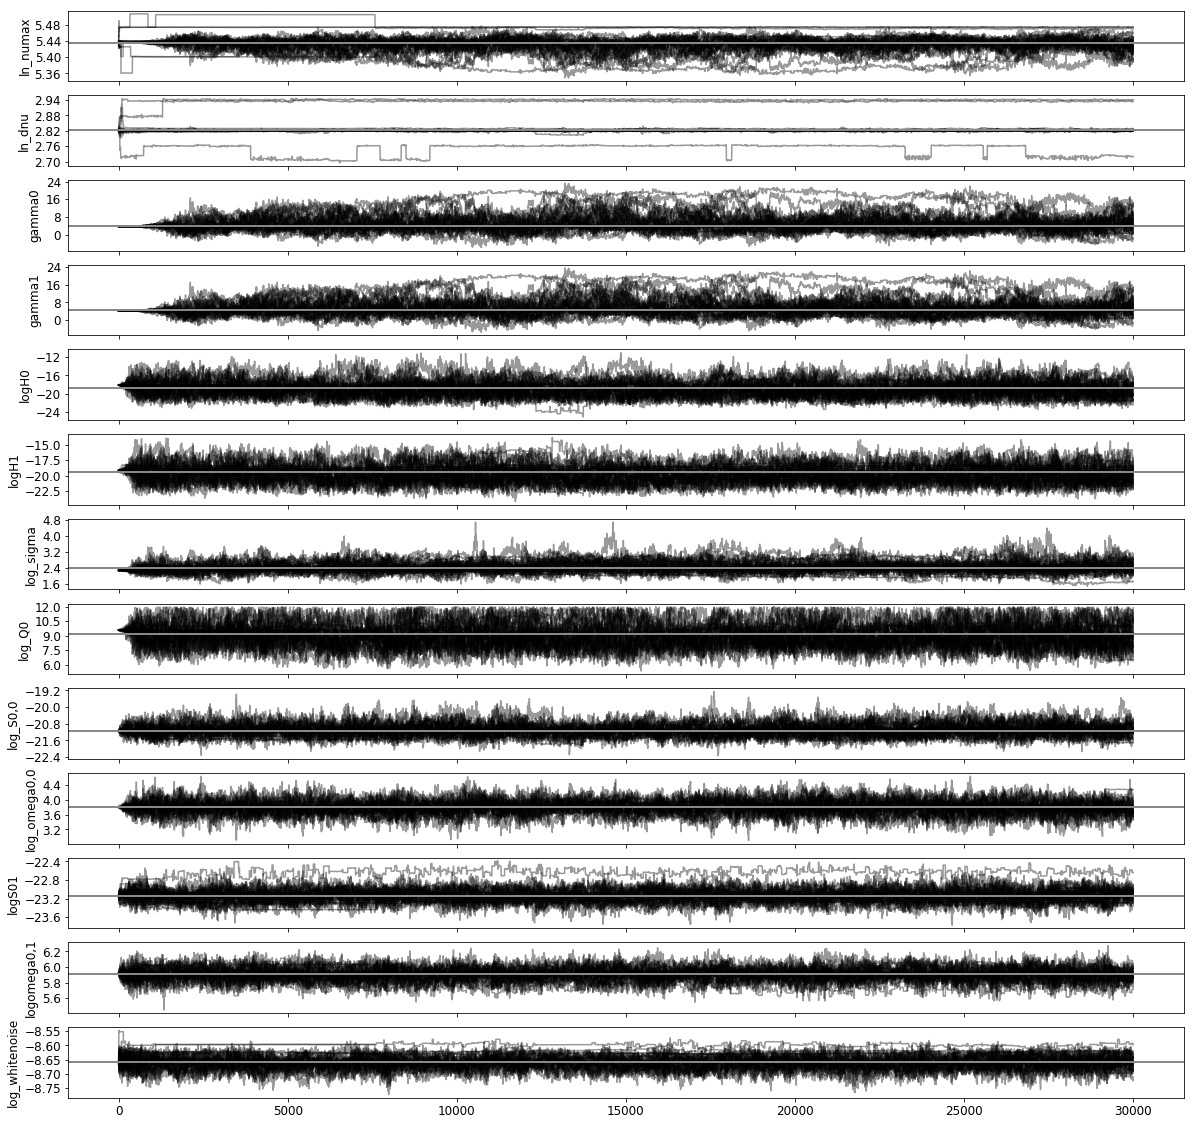

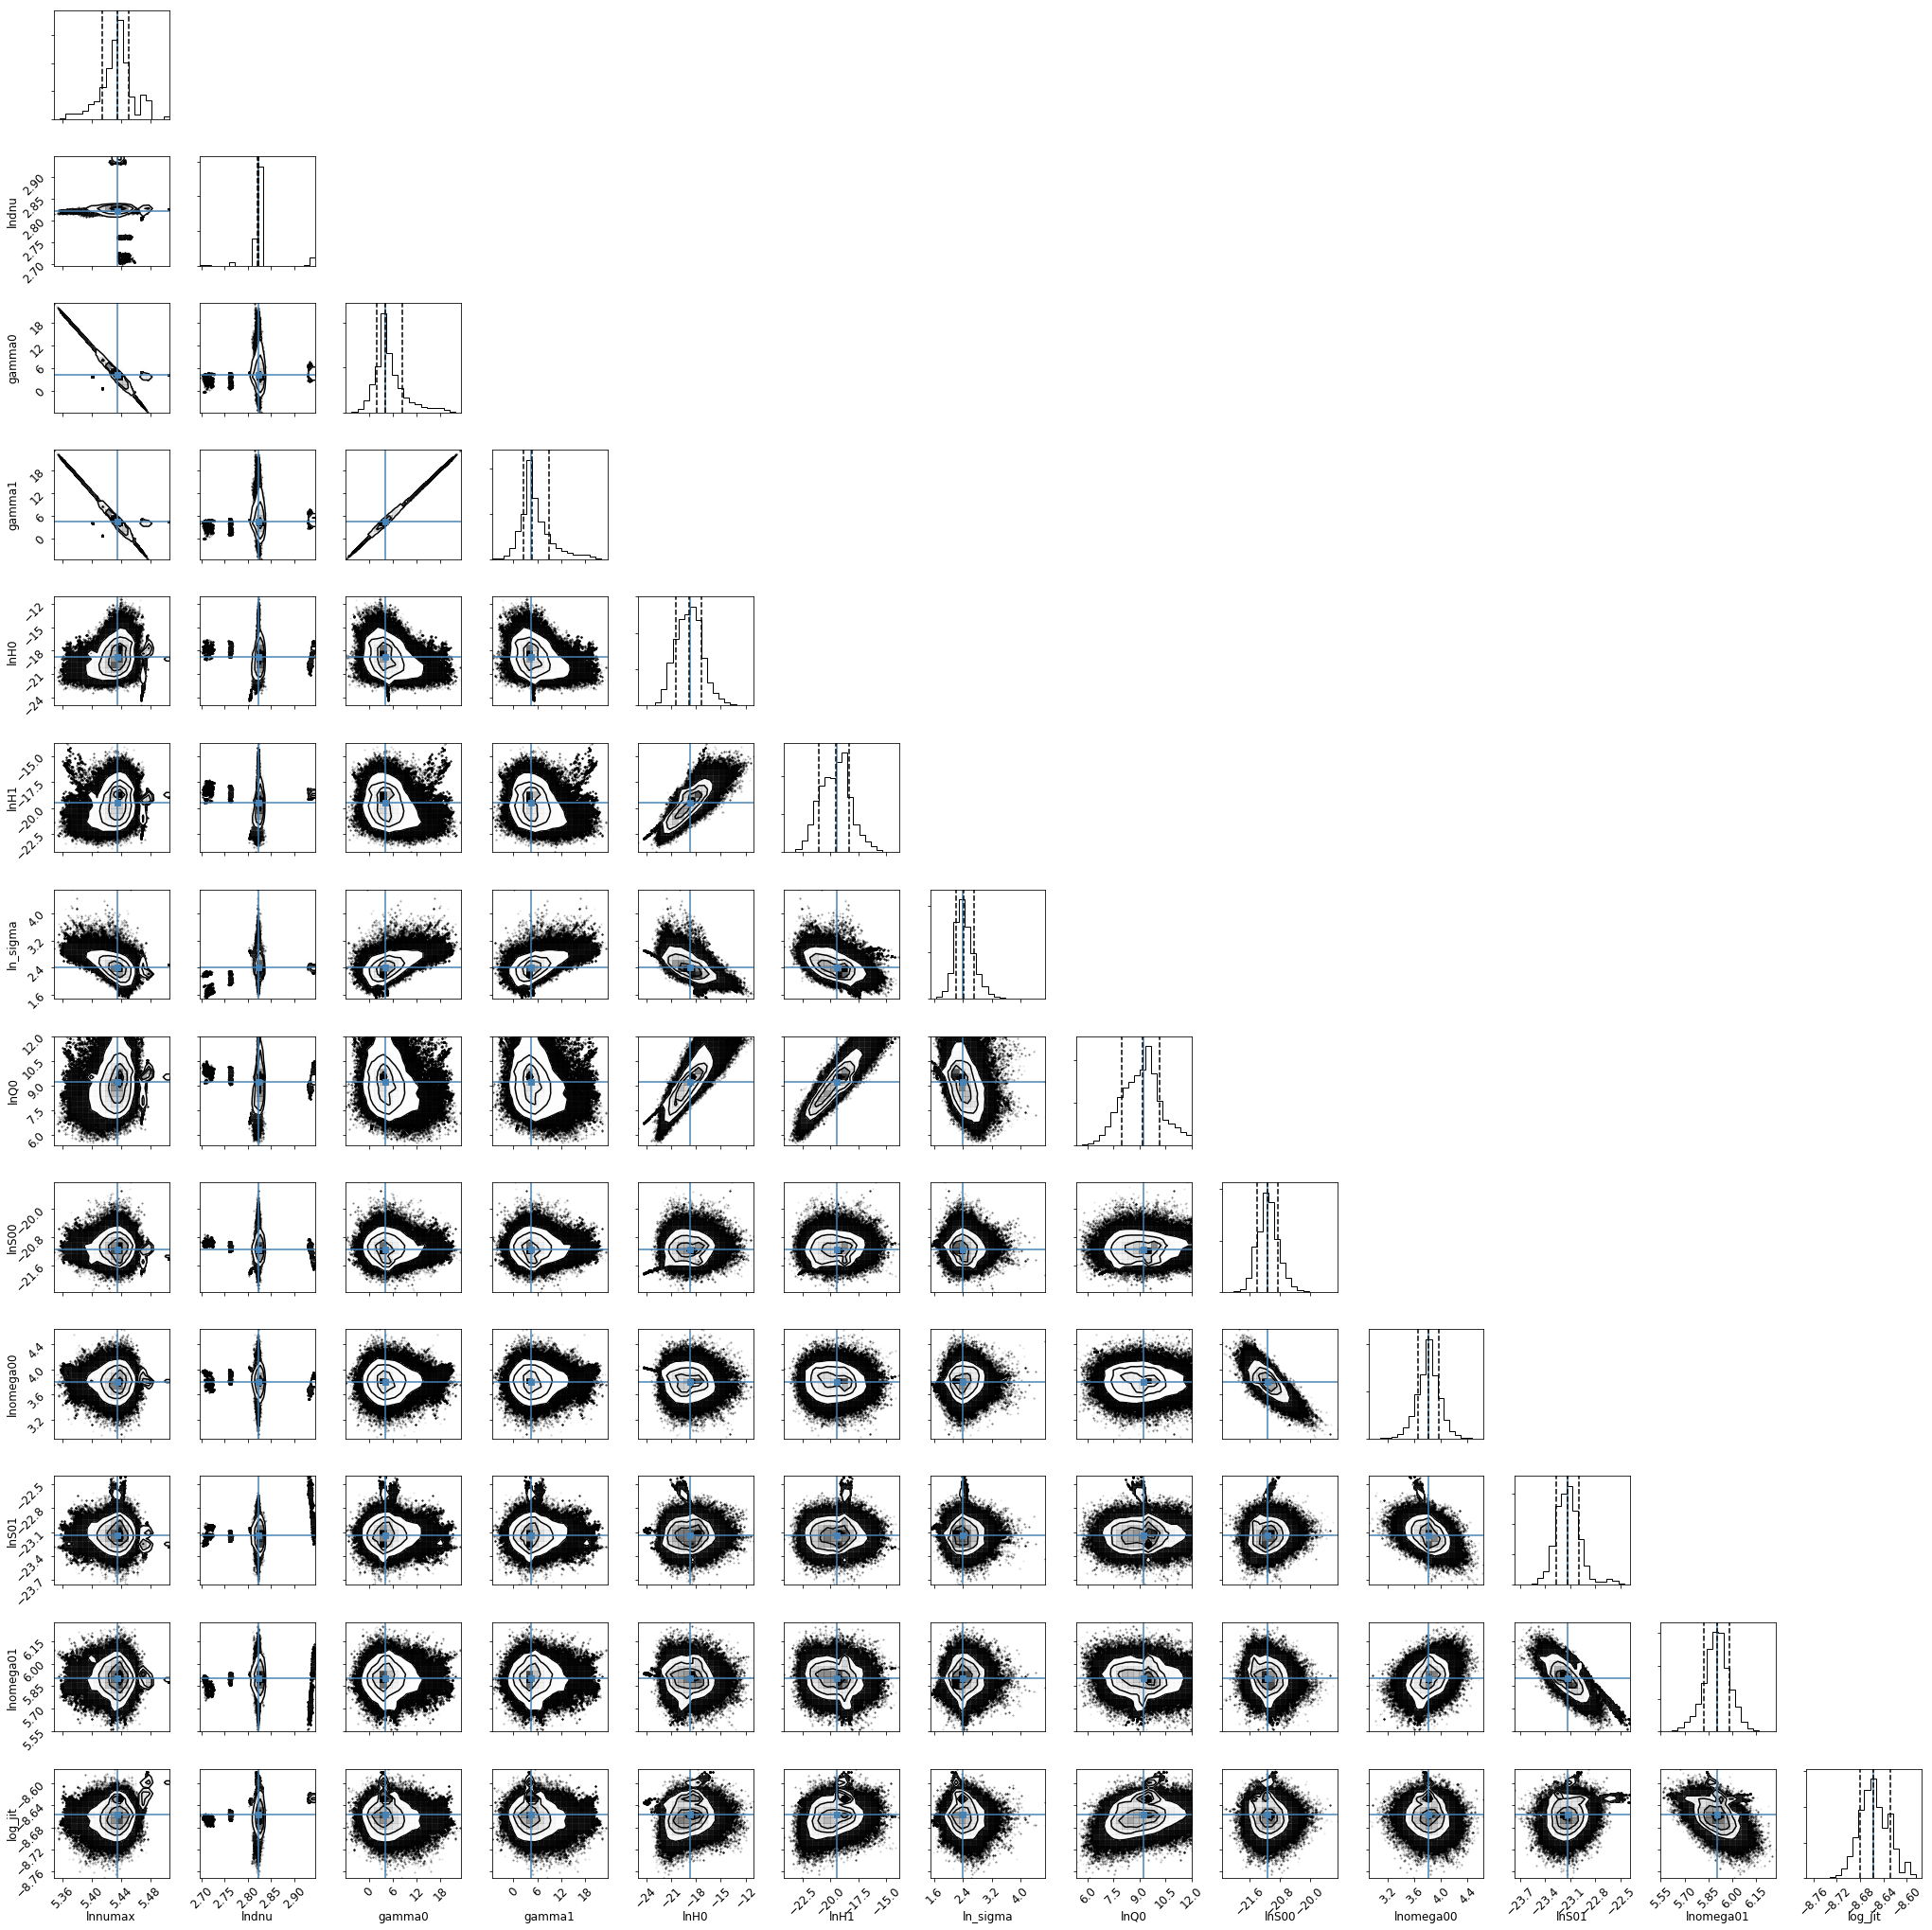

In [642]:
plt.clf()
fig, axes = plt.subplots(len(merged_par), 1, sharex=True, figsize=(20, 20))
axes[0].plot((sampler.chain[:, :, 0].T), color="k", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(np.median(sampler.chain[:, :, 0].T), color="#888888", lw=2)
axes[0].set_ylabel(r"ln_numax")
    
axes[1].plot((sampler.chain[:, :, 1].T), color="k", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(np.median(sampler.chain[:, :, 1].T), color="#888888", lw=2)
axes[1].set_ylabel(r"ln_dnu")

axes[2].plot((sampler.chain[:, :, 2].T), color="k", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(np.median(sampler.chain[:, :, 2].T), color="#888888", lw=2)
axes[2].set_ylabel(r"gamma0")
    
axes[3].plot((sampler.chain[:, :, 3].T), color="k", alpha=0.4)
axes[3].yaxis.set_major_locator(MaxNLocator(5))
axes[3].axhline(np.median(sampler.chain[:, :, 3].T), color="#888888", lw=2)
axes[3].set_ylabel(r"gamma1")

axes[4].plot((sampler.chain[:, :, 4].T), color="k", alpha=0.4)
axes[4].yaxis.set_major_locator(MaxNLocator(5))
axes[4].axhline(np.median(sampler.chain[:, :, 4].T), color="#888888", lw=2)
axes[4].set_ylabel(r"logH0")

axes[5].plot((sampler.chain[:, :, 5].T), color="k", alpha=0.4)
axes[5].yaxis.set_major_locator(MaxNLocator(5))
axes[5].axhline(np.median(sampler.chain[:, :, 5].T), color="#888888", lw=2)
axes[5].set_ylabel(r"logH1")

axes[6].plot((sampler.chain[:, :, 6].T), color="k", alpha=0.4)
axes[6].yaxis.set_major_locator(MaxNLocator(5))
axes[6].axhline(np.median(sampler.chain[:, :, 6].T), color="#888888", lw=2)
axes[6].set_ylabel(r"log_sigma")

axes[7].plot((sampler.chain[:, :, 7].T), color="k", alpha=0.4)
axes[7].yaxis.set_major_locator(MaxNLocator(5))
axes[7].axhline(np.median(sampler.chain[:, :, 7].T), color="#888888", lw=2)
axes[7].set_ylabel(r"log_Q0")

axes[8].plot((sampler.chain[:, :, 8].T), color="k", alpha=0.4)
axes[8].yaxis.set_major_locator(MaxNLocator(5))
axes[8].axhline(np.median(sampler.chain[:, :, 8].T), color="#888888", lw=2)
axes[8].set_ylabel(r"log_S0,0")

axes[9].plot((sampler.chain[:, :, 9].T), color="k", alpha=0.4)
axes[9].yaxis.set_major_locator(MaxNLocator(5))
axes[9].axhline(np.median(sampler.chain[:, :, 9].T), color="#888888", lw=2)
axes[9].set_ylabel(r"log_omega0,0")

axes[10].plot((sampler.chain[:, :, 10].T), color="k", alpha=0.4)
axes[10].yaxis.set_major_locator(MaxNLocator(5))
axes[10].axhline(np.median(sampler.chain[:, :, 10].T), color="#888888", lw=2)
axes[10].set_ylabel(r"logS01")

axes[11].plot((sampler.chain[:, :, 11].T), color="k", alpha=0.4)
axes[11].yaxis.set_major_locator(MaxNLocator(5))
axes[11].axhline(np.median(sampler.chain[:, :, 11].T), color="#888888", lw=2)
axes[11].set_ylabel(r"logomega0,1")

axes[12].plot((sampler.chain[:, :, 12].T), color="k", alpha=0.4)
axes[12].yaxis.set_major_locator(MaxNLocator(5))
axes[12].axhline(np.median(sampler.chain[:, :, 12].T), color="#888888", lw=2)
axes[12].set_ylabel(r"log_whitenoise")


import corner
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


majorFormatter = FormatStrFormatter('%.2f')
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(majorFormatter)

plt.clf()
plt.rcParams["font.size"] = 12
#plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
#plt.rcParams["text.usetex"] = True
#plt. rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
#plt.rcParams['font.size']=18  
fig = corner.corner(samples, labels=[r"lnnumax", r"lndnu", r"gamma0", r"gamma1", r"lnH0", r"lnH1", r"ln_sigma",\
                                     r"lnQ0", r"lnS00", r"lnomega00", r"lnS01", r"lnomega01", "log_jit"], quantiles=[0.16, 0.5, 0.84],
                      truths=[np.median(sampler.chain[:, :, 0].T), np.median(sampler.chain[:, :, 1].T), np.median(sampler.chain[:, :, 2].T), \
                              np.median(sampler.chain[:, :, 3].T), np.median(sampler.chain[:, :, 4].T), np.median(sampler.chain[:, :, 5].T), \
                              np.median(sampler.chain[:, :, 6].T), np.median(sampler.chain[:, :, 7].T), np.median(sampler.chain[:, :, 8].T), \
                              np.median(sampler.chain[:, :, 9].T), np.median(sampler.chain[:, :, 10].T), np.median(sampler.chain[:, :, 11].T), \
                              np.median(sampler.chain[:, :, 12].T)])
    
fig.tight_layout()
